In [ ]:
# data_generator.py (데이터 생성 코드)
import pandas as pd
import random
import os  # 폴더 생성을 위해 필요

# 1. 격식(Formal) 문장 패턴 (교수님/조교님 대상)
formal_templates = [
    "교수님, 이번 과제 제출 기한을 하루만 연장해주실 수 있으신가요?",
    "안녕하세요, 수업 내용 중 이해가 가지 않는 부분이 있어 메일 드립니다.",
    "조교님, 랩미팅 시간은 언제 확정되는지 여쭤봐도 될까요?",
    "출석 인정 관련하여 증빙 서류를 제출하고자 합니다.",
    "성적 이의 신청 기간이 언제까지인지 궁금합니다.",
    "혹시 상담 가능하신 시간이 언제이신지 알려주시면 감사하겠습니다.",
    "지난 수업 때 말씀하신 논문 자료를 찾을 수가 없습니다.",
    "개인적인 사정으로 인해 금일 수업 참석이 어려울 것 같습니다.",
    "팀 프로젝트 조 편성 문제로 문의드립니다.",
    "졸업 요건과 관련하여 면담을 요청드려도 될까요?"
]

# 2. 비격식(Informal) 문장 패턴 (친구/후배 대상)
informal_templates = [
    "야 오늘 점심 뭐 먹을래?",
    "아 진짜 과제 개많네 ㅋㅋㅋ",
    "롤 하러 갈 사람 구함",
    "너 어제 수업 들었냐? 필기 좀 보여줘",
    "오늘 술 한잔 ㄱㄱ?",
    "이번 주말에 시간 됨?",
    "아 교수님 진도 너무 빨리 나가시는 거 아니냐",
    "시험 범위 어디까지라고 했지?",
    "이거 레포트 언제까지 내는 거임?",
    "ㅋㅋㅋㅋ 진짜 웃기네 인정"
]

# 3. 데이터 500개 뻥튀기 (랜덤 조합)
data = []
for _ in range(250): # 격식 250개
    text = random.choice(formal_templates)
    text = text.replace("?", ".") if random.random() > 0.5 else text
    data.append({'text': text, 'label': 1})

for _ in range(250): # 비격식 250개
    text = random.choice(informal_templates)
    data.append({'text': text, 'label': 0})

# 4. 셔플 및 저장
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# data 폴더 생성.
os.makedirs('data', exist_ok=True)

# CSV 파일 저장
df.to_csv('data/politeness_data_500.csv', index=False, encoding='utf-8-sig')

print("데이터 생성 완료: data/politeness_data_500.csv (총 500개)")

데이터 생성 완료: data/politeness_data_500.csv (총 500개)


ExtendedClassifier(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 5: Train Loss 0.1583, Val Loss 0.1027
Epoch 10: Train Loss 0.0590, Val Loss 0.0297
Epoch 15: Train Loss 0.0273, Val Loss 0.0107
Epoch 20: Train Loss 0.0154, Val Loss 0.0063
Epoch 25: Train Loss 0.0097, Val Loss 0.0036
Epoch 30: Train Loss 0.0078, Val Loss 0.0022


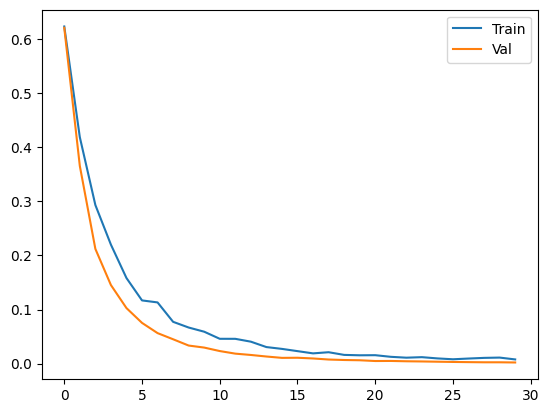

모델 저장 완료


In [ ]:
# training.ipynb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import os
import joblib

# 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# 1. 데이터 로드 (방금 만든 500개 파일 사용)
file_path = 'data/politeness_data_500.csv'
df = pd.read_csv(file_path)

# 벡터화 (단어 사전 크기를 2000으로 확장)
vectorizer = CountVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

# 데이터셋 분할 (Train 70% / Val 15% / Test 15%) - 데이터가 많아져서 비율 조정
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

class PolitenessDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# 배치 사이즈 증가 (4 -> 16)
train_loader = DataLoader(PolitenessDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(PolitenessDataset(X_val, y_val), batch_size=16, shuffle=False)

# 2. 확장된 모델 설계 (Deeper Neural Network)
class ExtendedClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ExtendedClassifier, self).__init__()
        # 첫 번째 층: 입력 -> 64 (뉴런 수 증가)
        self.layer1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64) # 배치 정규화 추가 (학습 안정화)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3) # 드롭아웃 강화

        # 두 번째 층: 64 -> 32 (층 추가)
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)

        # 세 번째 층: 32 -> 1 (출력)
        self.layer3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

model = ExtendedClassifier(input_dim=X.shape[1])
print(model)

# 3. 학습 시작
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30 # 데이터가 많아져서 Epoch 줄여도 됨

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Val Loss {val_losses[-1]:.4f}")

# 4. 저장
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()
plt.show()

os.makedirs('model_artifacts', exist_ok=True)
torch.save(model.state_dict(), 'model_artifacts/model_weights.pth')
joblib.dump(vectorizer, 'model_artifacts/vectorizer.pkl')
print("모델 저장 완료")